# Quality Control
This notebook calculates some key metrics and generates plots of them to assess the quality of the ATAC-seq and RNA-seq data sets.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

DATA_DIR = "data/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
MMC1_PATH = os.path.join(DATA_DIR, "mmc1.xlsx")

#Load the ATAC-seq data
atac_raw = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])

#Load the RNA-seq data
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)

#Load the meta data
meta1 = pd.read_excel(MMC1_PATH, sheet_name="SortedPopulations")
meta1 = meta1.set_index("SampleName").groupby("CellType")
meta2 = pd.read_excel(MMC1_PATH, sheet_name="Read Statistics")
meta2 = meta2.set_index("sample.name").groupby("population.name")

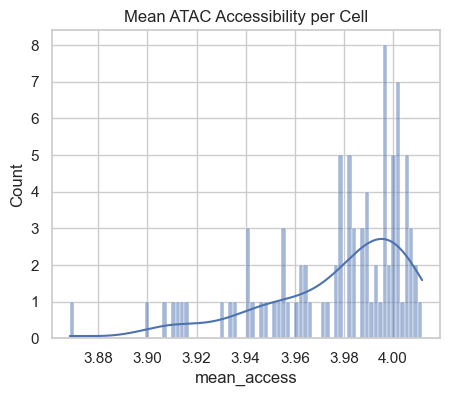

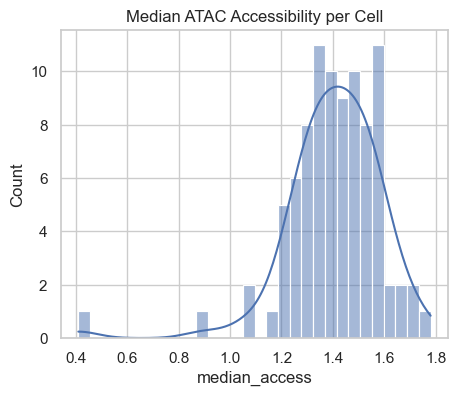

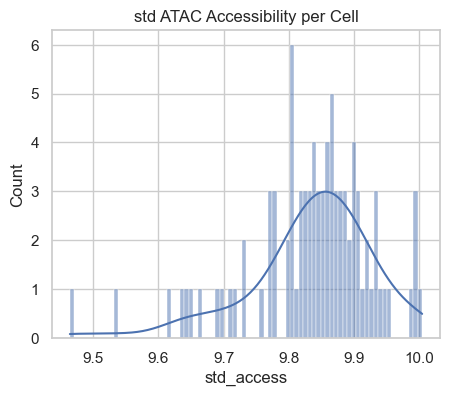

In [31]:
#remove data that aren't cell populations
atac = atac_raw.drop(columns=["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"]).select_dtypes(include=[np.number])
# 1. Compute per‐cell stats
cell_stats = pd.DataFrame({
    "mean_access":   atac.mean(axis=0, numeric_only=True),
    "median_access": atac.median(axis=0, numeric_only=True),
    "std_access":    atac.std(axis=0, numeric_only=True)
})

# 2. Visualize
sns.set_theme(style="whitegrid")

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["mean_access"], bins=80, kde=True)
plt.title("Mean ATAC Accessibility per Cell")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["median_access"], bins=30, kde=True)
plt.title("Median ATAC Accessibility per Cell")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(cell_stats["std_access"], bins=80, kde=True)
plt.title("std ATAC Accessibility per Cell")
plt.show()

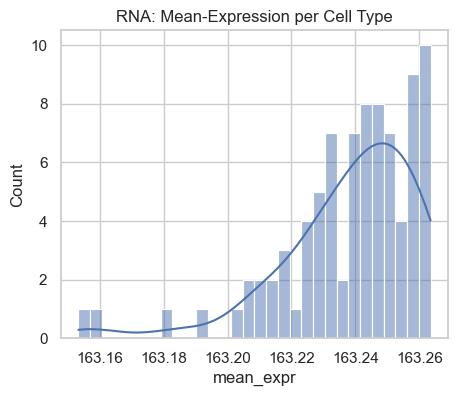

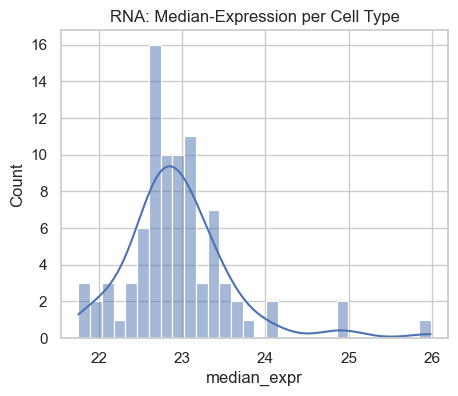

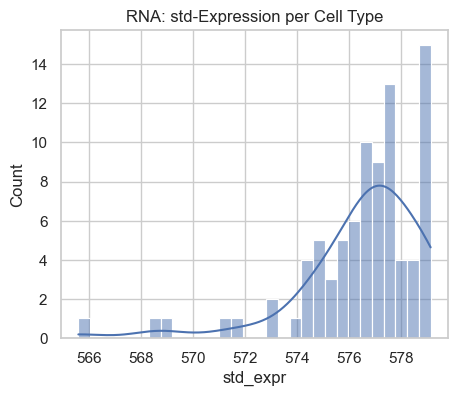

In [3]:
rna_cell_stats = pd.DataFrame({
    "mean_expr":   rna.mean(axis=0),
    "median_expr": rna.median(axis=0),
    "std_expr":    rna.std(axis=0)
})
# Merge QC if desired (e.g. InputCellNumber)
#if "PF.reads" in meta1.columns:
#    rna_cell_stats["PF.reads"] = meta1.groupby("CellType")["PF.reads"].sum()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["mean_expr"], bins=30, kde=True)
plt.title("RNA: Mean-Expression per Cell Type")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["median_expr"], bins=30, kde=True)
plt.title("RNA: Median-Expression per Cell Type")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["std_expr"], bins=30, kde=True)
plt.title("RNA: std-Expression per Cell Type")
plt.show()

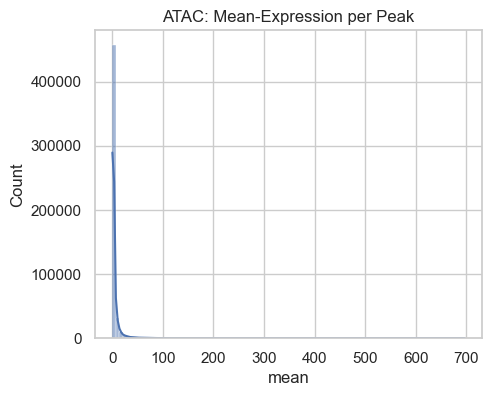

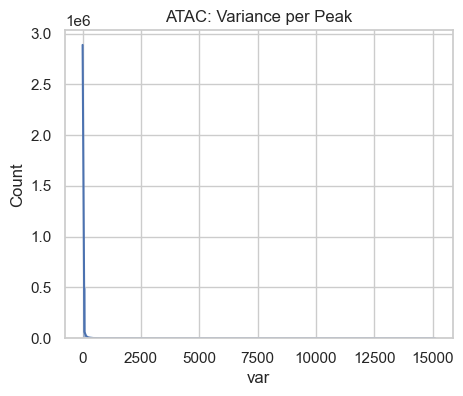

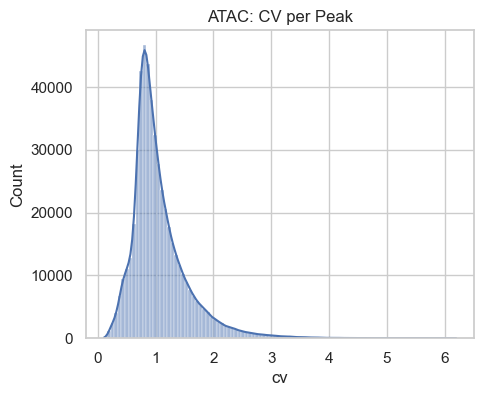

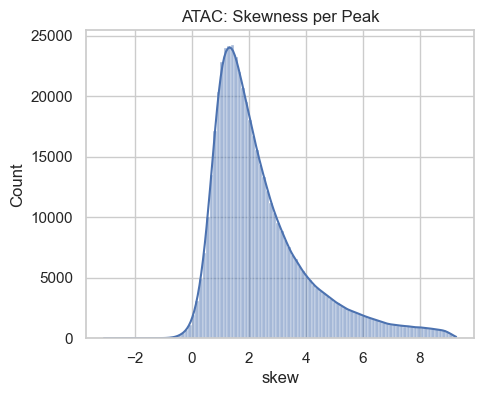

In [4]:
from scipy.stats import skew

# 4.1 Peak stats
peak_stats = pd.DataFrame({
    "mean": atac.mean(axis=1, numeric_only=True),
    "var":  atac.var(axis=1, numeric_only=True),
    "cv":   atac.std(axis=1, numeric_only=True)/(atac.mean(axis=1, numeric_only=True)+1e-6),
    "skew": atac.select_dtypes(include=[np.number]).apply(lambda row: skew(row), axis=1),
    "peak_range": atac.max(axis=1, numeric_only=True) - atac.min(axis=1, numeric_only=True)
})

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["mean"], bins=100, kde=True)
plt.title("ATAC: Mean-Expression per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["var"], bins=100, kde=True)
plt.title("ATAC: Variance per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["cv"], bins=100, kde=True)
plt.title("ATAC: CV per Peak")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(peak_stats["skew"], bins=100, kde=True)
plt.title("ATAC: Skewness per Peak")
plt.show()

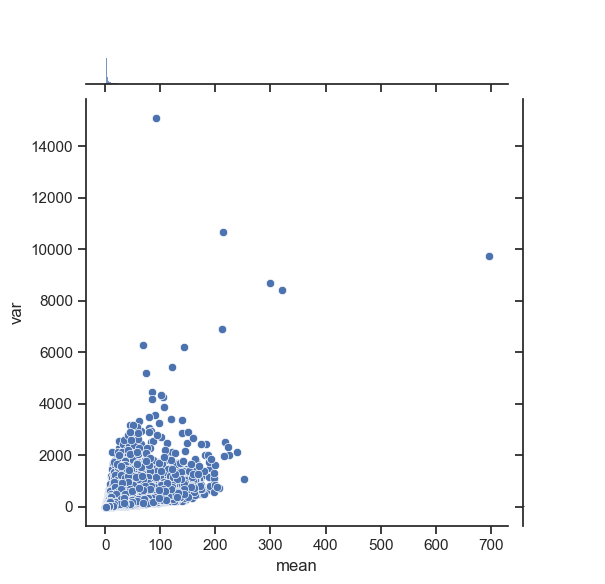

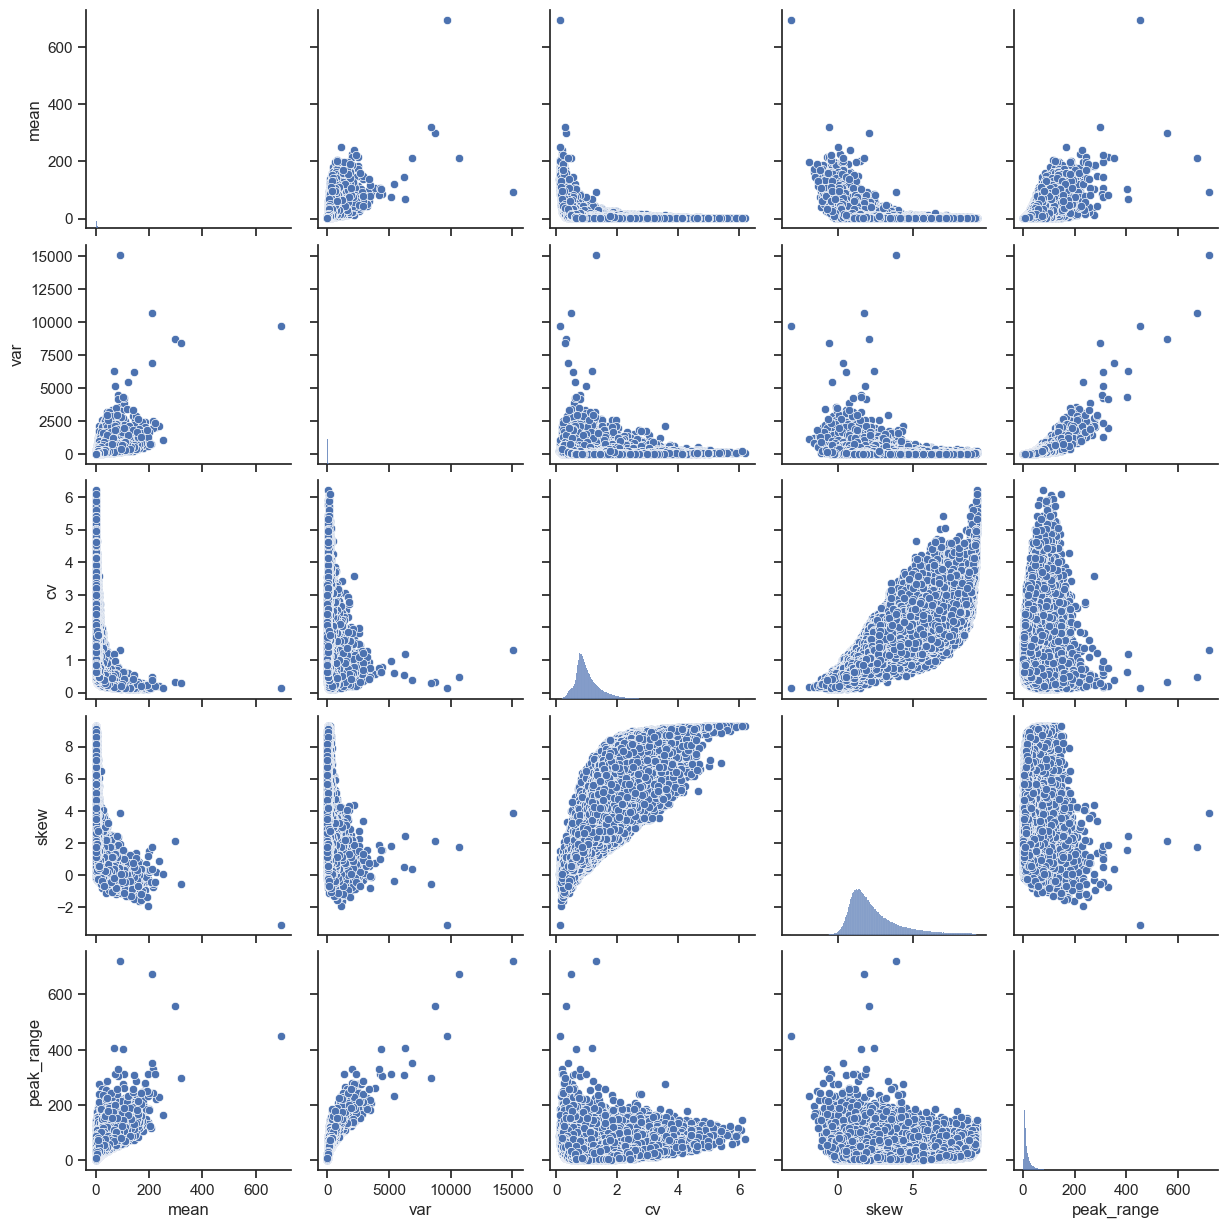

In [5]:
sns.set_theme(style="ticks")

sns.jointplot(
    x="mean", y="var",
    data=peak_stats
)
#plt.title("Hexbin plot for ATAC: Mean vs Variance per Peak")
plt.show()

sns.pairplot(peak_stats)
plt.show()

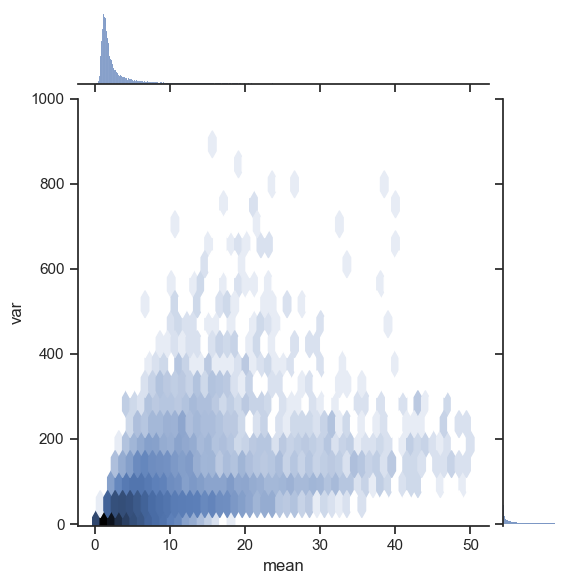

In [6]:
sns.jointplot(
    x="mean", y="var",
    data=peak_stats[peak_stats["mean"] <= 50].sample(50000),
    kind="hex",
    bins="log",
    gridsize=50,
    #xlim= (0, 25),
    ylim= (-5, 1000),
)
plt.show()

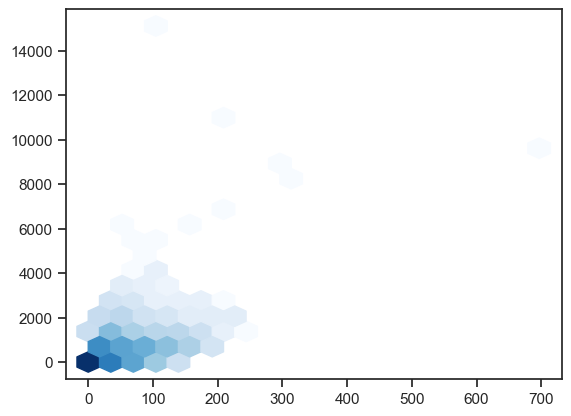

In [7]:
plt.hexbin(peak_stats["mean"], peak_stats["var"], bins="log", gridsize=20, cmap="Blues")

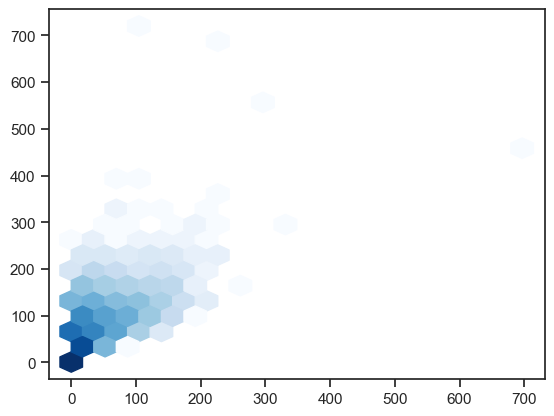

In [8]:
plt.hexbin(peak_stats["mean"], peak_stats["peak_range"], bins="log", gridsize=20, cmap="Blues")

- 1. i. a. Is the signal (median, mean, std) dependent on the sequencing depth, number of input cells, or another QC metric?

In [21]:
meta_sum = meta1.sum().drop(columns=["%chrM.mapped", "%fragment.1Kb_TSS", "Replicate.cor"]).join(meta2.sum().drop(columns=["overal_ alignment_rate%"]))
meta_mean = meta1[["%chrM.mapped", "%fragment.1Kb_TSS", "Replicate.cor"]].mean().join(meta2["overal_ alignment_rate%"].mean())
meta = pd.concat([meta_sum, meta_mean], axis=1)

# Calculate addition stats
meta["%duplicates"] = (meta["total.reads"]- meta["reads.after.removing.duplication"]) / meta["total.reads"] * 100

#meta = meta.drop(columns=["%chrM.mapped", "%fragment.1Kb_TSS", "overal_ alignment_rate%", "Replicate.cor"]) #TODO: proper calculation
meta_num = meta.select_dtypes([np.number])

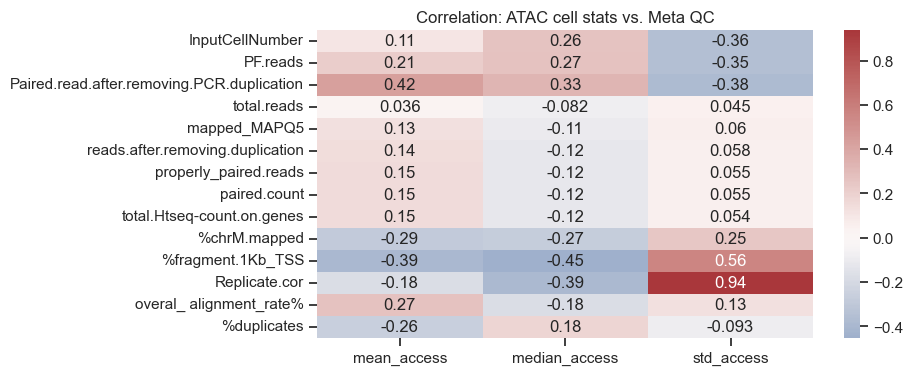

In [22]:
atac_correlation = pd.DataFrame(columns=cell_stats.columns, index=meta_num.columns)
for col in cell_stats.columns:
    for key in meta_num.columns:
        atac_correlation.loc[key, col] = cell_stats[col].corr(meta[key], method='pearson') 

plt.figure(figsize=(8, 4))
sns.heatmap(atac_correlation.astype(float), annot=True, cmap="vlag", center=0)
plt.title("Correlation: ATAC cell stats vs. Meta QC")
plt.show()

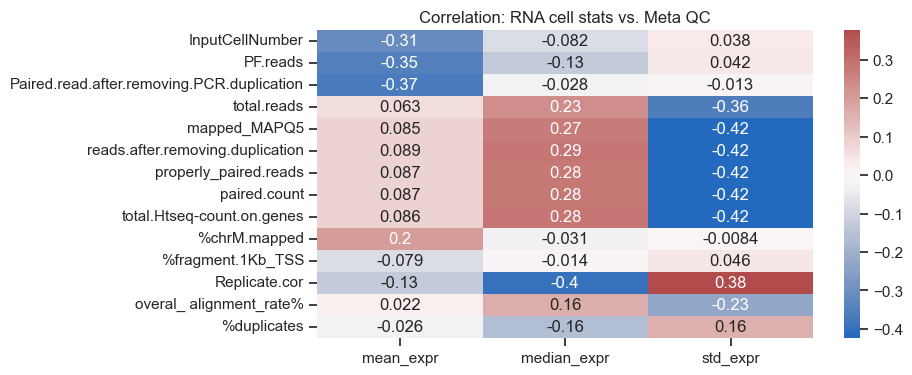

In [23]:
rna_correlation = pd.DataFrame(columns=rna_cell_stats.columns, index=meta_num.columns)
for col in rna_cell_stats.columns:
    for key in meta_num.columns:
        rna_correlation.loc[key, col] = rna_cell_stats[col].corr(meta[key], method='pearson') 

plt.figure(figsize=(8, 4))
sns.heatmap(rna_correlation.astype(float), annot=True, cmap="vlag", center=0)
plt.title("Correlation: RNA cell stats vs. Meta QC")
plt.show()

In [28]:
qc = cell_stats.join(meta_num)
qc

,mean_access,median_access,std_access,InputCellNumber,PF.reads,Paired.read.after.removing.PCR.duplication,total.reads,mapped_MAPQ5,reads.after.removing.duplication,properly_paired.reads,paired.count,total.Htseq-count.on.genes,%chrM.mapped,%fragment.1Kb_TSS,Replicate.cor,overal_ alignment_rate%,%duplicates
LTHSC.34-.BM,3.868438,0.41,10.004101,677.0,22287984.0,2470102.0,43067138.0,22957367.0,14493802.0,13686212.0,6843106.0,6626929.0,4.580,10.600,NaN,55.790,66.346029
LTHSC.34+.BM,4.005767,1.64,9.986633,2483.0,28588536.0,7675501.0,38923270.0,22716102.0,14680971.0,13915876.0,6957938.0,6739844.0,3.170,7.700,NaN,61.275,62.282277
STHSC.150-.BM,4.001125,0.90,9.991892,3660.0,22170346.0,6060045.0,39284840.0,20774388.0,12994614.0,12255642.0,6127821.0,5932427.0,3.250,11.130,NaN,55.560,66.922065
MPP4.135+.BM,4.002324,1.58,9.994831,10000.0,24003590.0,6128252.0,41805104.0,23466146.0,14841151.0,13993436.0,6996718.0,6779185.0,13.830,18.960,NaN,58.900,64.499189
proB.CLP.BM,4.008413,1.26,9.772241,20000.0,43806828.0,12694753.0,39730230.0,23787860.0,14960964.0,14207150.0,7103575.0,6878272.0,9.035,15.605,0.868,62.955,62.343626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FRC.SLN,3.998828,1.47,9.808067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IAP.SLN,3.987949,1.40,9.614775,20000.0,47040542.0,16294630.0,27447976.0,15221272.0,10578545.0,9958388.0,4979194.0,4815914.0,2.635,11.920,0.810,58.665,61.459654
BEC.SLN,3.983416,1.54,9.709456,20000.0,73428210.0,21733127.0,48537618.0,25141376.0,16235883.0,15364130.0,7682065.0,7473212.0,4.710,8.445,0.846,54.115,66.549897
LEC.SLN,3.976234,1.57,9.715224,20000.0,60787252.0,16703816.0,59385388.0,33606261.0,20962015.0,20042274.0,10021137.0,9731086.0,6.875,5.305,0.887,59.370,64.701729


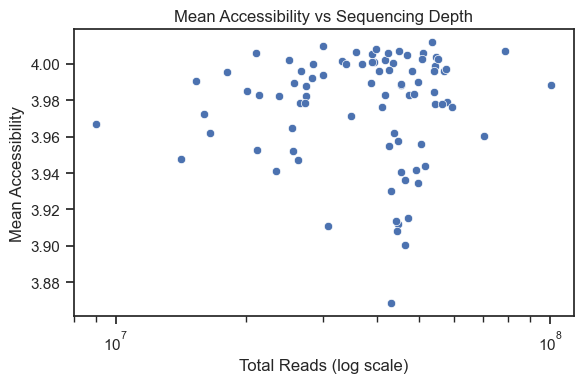

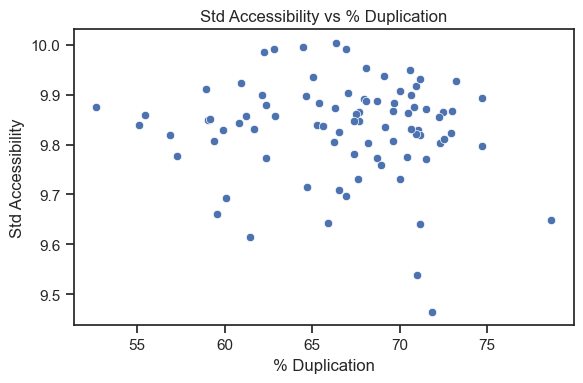

In [18]:
# Scatter: mean_access vs total_reads
plt.figure(figsize=(6,4))
sns.scatterplot(x='total.reads', y='mean_access', data=qc)
plt.xscale('log')
plt.title('Mean Accessibility vs Sequencing Depth')
plt.xlabel('Total Reads (log scale)')
plt.ylabel('Mean Accessibility')
plt.tight_layout(); plt.show()

# Similarly for std_access vs pct_duplication
plt.figure(figsize=(6,4))
sns.scatterplot(x='%duplicates', y='std_access', data=qc)
plt.title('Std Accessibility vs % Duplication')
plt.xlabel('% Duplication')
plt.ylabel('Std Accessibility')
plt.tight_layout(); plt.show()

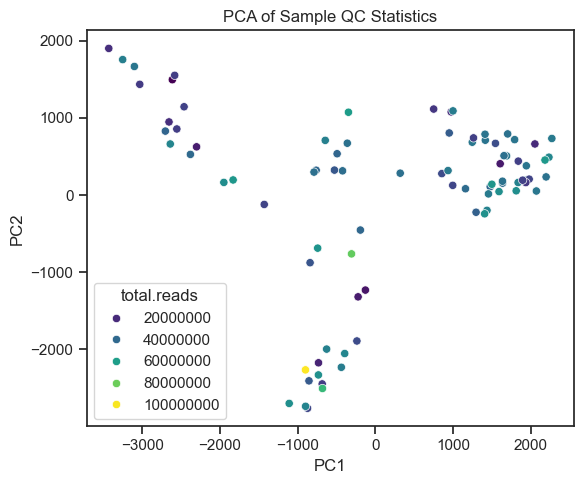

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#coords = pca.fit_transform(cell_stats[['mean_access','std_access']])  # or atac.T for full matrix
coords = pca.fit_transform(atac.T) 

plt.figure(figsize=(6,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=qc['total.reads'], palette='viridis')
plt.title('PCA of Sample QC Statistics')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout(); plt.show()

- 1. i. b. Should some cell types be removed from downstream analysis, or should we apply additional normalization?

There are no clear outliers in the above analysis so we will work with all of the cell types.